# Элементарные алгоритмы обработки временных рядов

In [ ]:
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба 
эти варианта моделями из класса MA. 
Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sales_of_company_x = pd.read_csv("/home/lena/Netology/Time_Series/Series/monthly-sales-of-company-x-jan-6.csv")

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
from scipy.stats import boxcox

In [6]:
X_nostat = sales_of_company_x.Count

In [7]:
X = boxcox(X_nostat, 0)

In [8]:
dftest = adfuller(X, autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
dtype: float64

In [9]:
import numpy as np
X = np.diff(X, 5)

In [10]:
dftest = adfuller(X, autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

Test Statistic                -6.601096e+00
p-value                        6.732854e-09
#Lags Used                     1.200000e+01
Number of Observations Used    5.900000e+01
dtype: float64

In [ ]:
У нас есть ряд X_nostat - оригинальный нестационарный ряд, 
а ряд X - стационарный (после применения Бокса-Кокса и дифференцирования).

In [ ]:
Применим стандартные алгоритмы к нашем рядам:
    1. Скользящее среднее
    2. Взвешенное скользящее среднее
    3. Экспоненциальное сглаживание

In [11]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [12]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [13]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [14]:
ema = exponential_moving_average(X_nostat, 0.7)
wma = weighted_moving_average(X_nostat, 5, [1,1,2,3,5])
ma = moving_average(X_nostat, 5)

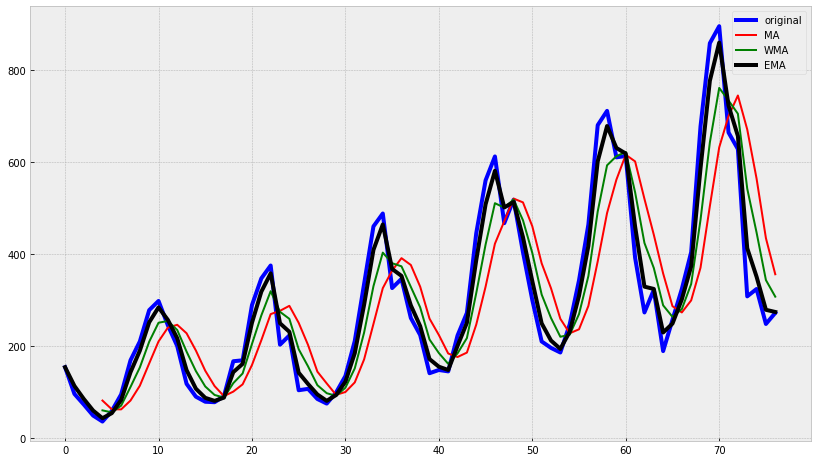

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(X_nostat, color='blue',  linewidth='4', label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
Видим, что для оригинального ряда экспоненциальное сглаживание хорошо описывает наш ряд.

In [16]:
ema = exponential_moving_average(X, 0.7)
wma = weighted_moving_average(X, 5, [1,1,2,3,5])
ma = moving_average(X, 5)

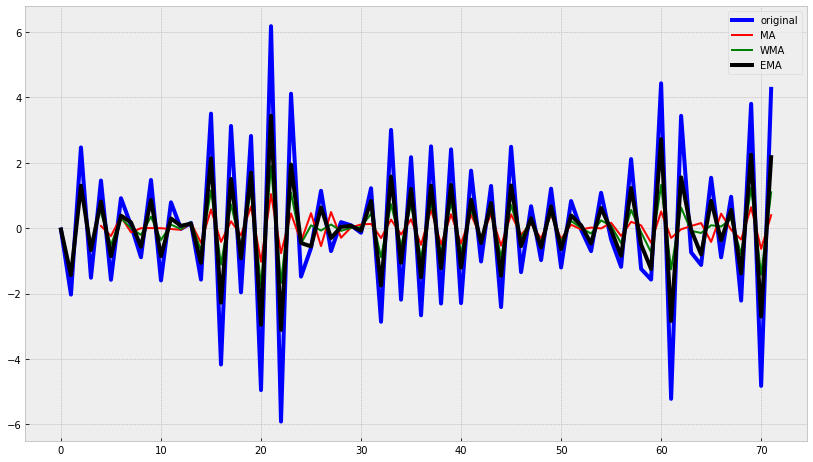

In [17]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(X, color='blue',  linewidth='4', label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
Для стационарного ряда экспоненциальное сглаживание хорошо попадает в колебания, но не видит пиков.

In [ ]:
Для оригинального ряда применим метод Хольта-Винтерса, так как у нас есть сезонность. 

In [18]:
i=0
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [19]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [20]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [21]:
def plot_tema(alpha, beta, gamma, ser=X_nostat, ser_to_plot=X_nostat, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='4', label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

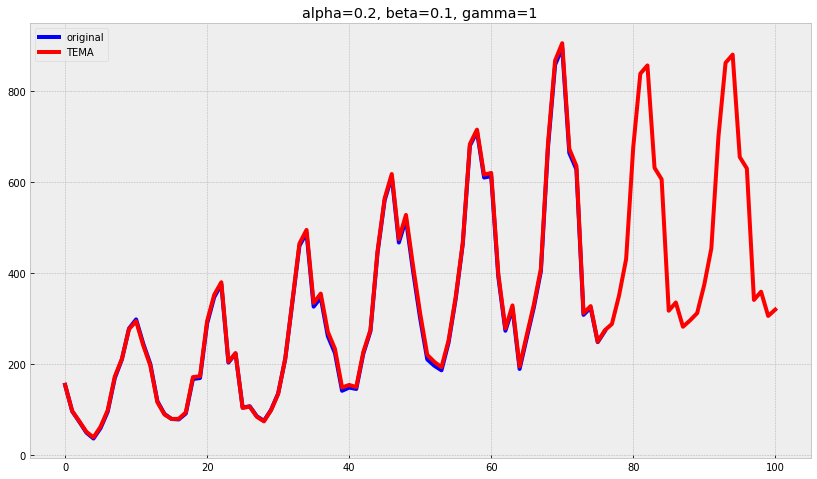

In [22]:
plot_tema(0.2, 0.1, 1)

In [ ]:
Видим, что данный метод очень хорошо описал наш ряд и сделал приемлимый прогноз. 

In [ ]:
Подберем наилучшие коэффициенты:

In [23]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [24]:
series = X_nostat

In [25]:
train, test, val = series[:60], series[60:70], series[70:]

In [26]:
def mse(d):
    alpha, beta, gamma = d
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [27]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [28]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2932.09118958614
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.43700163e-02,  1.28693500e-02, -1.01781739e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 184
      nit: 29
   status: 0
  success: True
        x: array([0.26928456, 0.1226514 , 1.        ])


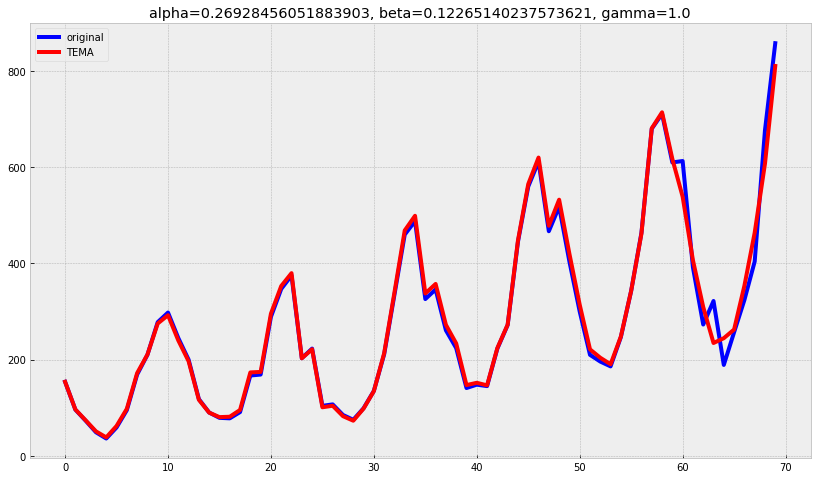

In [29]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

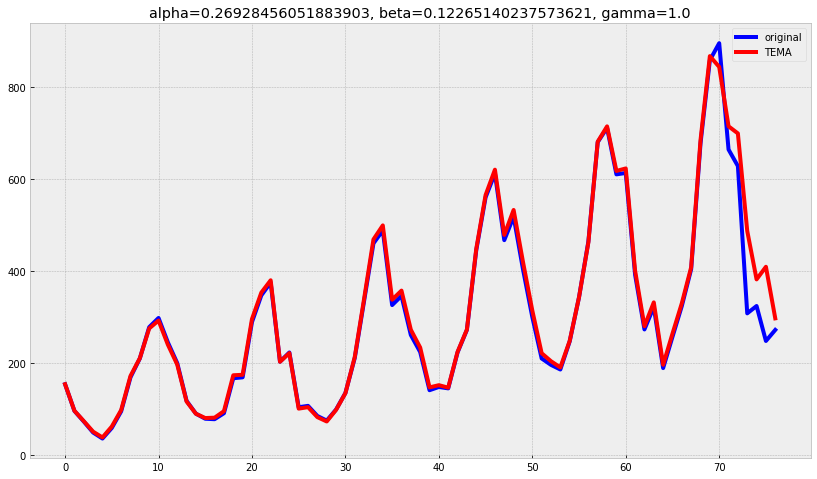

In [30]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [ ]:
Для стационарного ряда используем метод двойного экспоненциального сглаживания,
так как у нас нет сезонности.

In [31]:
series = X

In [32]:
def double_ema(series, alpha, beta, n_preds=0):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [33]:
def plot_dema(alpha, beta, series, ser_to_plot=series, n_preds=0):
    dema = double_ema(X, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(X, color='blue',linewidth='4', label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

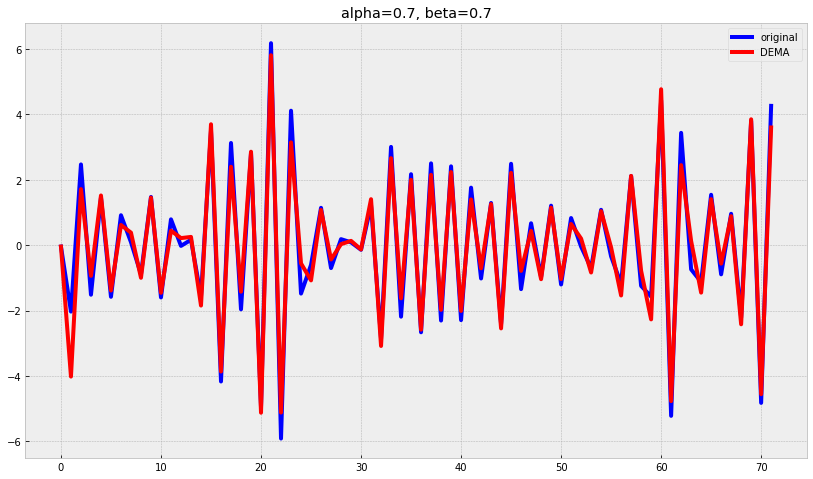

In [34]:
plot_dema(0.7, 0.7, series)